In [ ]:
import numpy as np
import tensorflow as tf
# next line only for colab
%tensorflow_version 2.x
tfkl = tf.keras.layers
from tensorflow.keras import Model
# import tensorflow-datasets to be able to access the tensorflow inbuilt datasets
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# 1. Dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

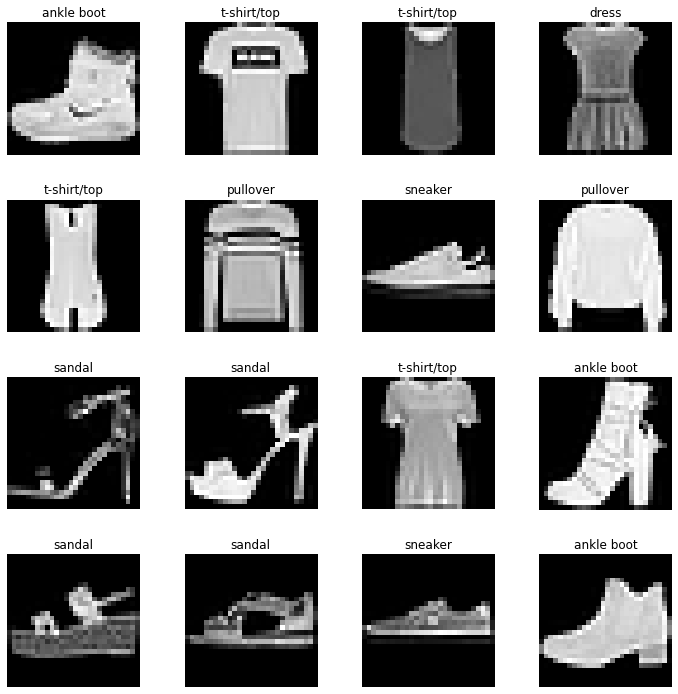

In [ ]:
# Plot some images together with their labels
label_names = ["t-shirt/top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
fig, ax = plt.subplots(4,4, figsize = (10,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(16):
  ax[i].imshow(train_images[i], cmap = "gray")
  ax[i].set_title(label_names[int(train_labels[i])])
  ax[i].axis('off')

## Input Pipeline

In [ ]:
# Since we are dealing with GAN we do not need the labels in our train and test datasets
# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)

# We normalize the images to a scale between 1 and 0.
# Furthermore, we use the .cache() function to store the data we need later in our memory for faster training 
train_dataset = train_dataset_images.map(lambda img: tf.cast(tf.expand_dims(img/255,-1), tf.float32)).cache().shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(64).prefetch(tf.data.experimental.AUTOTUNE)


# Repeat for test data
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset = test_dataset_images.map(lambda img: tf.cast(tf.expand_dims(img/255,-1), tf.float32)).cache().shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(64).prefetch(tf.data.experimental.AUTOTUNE)


# 2. Model

## Discriminator

In [ ]:
class Discriminator(Model):

  def __init__(self, num_filters=[64,128], kernel_size=3, stride=2, padding_option='same', activation_func='relu'):
    """Initialize a Discriminator that decides whether the input image is fake or real 

    Arguments:
      num_filters (list): Contains the number of filters for the hidden convolutional layers, per default [64,128]
      kernel_size (int): Used to set the kernel size of the hidden convolutional layers, per default 3
      stride (int): Used to set the stride size of the hidden convolutional layers, per default 2
      padding_option (string): Used to set the stride size of the hidden convolutional layers, per default 'same'
      activation_function (string): Used to set the activation function of the hidden convolutional layers, per default 'relu'
    """ 
    super(Discriminator, self).__init__()

    self.filter1, self.filter2 = num_filters

    self.DiscriminatorLayers = [
      tfkl.Conv2D(filters=self.filter1, kernel_size=kernel_size, strides=stride, padding=padding_option, activation=activation_func),
      tfkl.Conv2D(filters=self.filter2, kernel_size=kernel_size, strides=stride, padding=padding_option, activation=activation_func),
      tfkl.Flatten(),
      tfkl.Dense(units=1, activation='sigmoid')
    ]

  @tf.function    
  def call(self, x, training = True):
    """Activate our Discriminator propagating the input through it layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our Discriminator
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Discriminator 

    Returns:
      x (Tensor): Tensor indicating whether the input is a fake or not 
    """
    for layer in self.DiscriminatorLayers:
      x = layer(x, training = training)
    return x

## Generator

In [ ]:
class Generator(Model):

  def __init__(self, num_filters=[128,64], kernel_size=3):
    """Initialize a Generator that decides creates a fake image from a random vector 
    All layers use no bias and intermediate BatchNorm

    Arguments:
      num_filters (list): Contains the number of filters for the first two hidden transposed convolutional layers, per default [128,64]
      kernel_size (int): Used to set the kernel size of the hidden transposed convolutional layers, per default 3
    """ 

    super(Generator, self).__init__()

    self.filter1, self.filter2 = num_filters

    self.GeneratorLayers = [
      tfkl.Dense(units=7*7*64, activation=None, use_bias=False),
      tfkl.BatchNormalization(),
      tfkl.ReLU(),
      tfkl.Reshape((7,7,64)),
      tfkl.Conv2DTranspose(filters=self.filter1, kernel_size=kernel_size, strides=1, padding='same', activation=None, use_bias=False),
      tfkl.BatchNormalization(),
      tfkl.ReLU(),
      tfkl.Conv2DTranspose(filters=self.filter2, kernel_size=kernel_size, strides=2, padding='same', activation=None, use_bias=False),
      tfkl.BatchNormalization(),
      tfkl.ReLU(),
      tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid', use_bias=False)
    ]
  
  @tf.function    
  def call(self, x, training = True):
    """Activate our Generator propagating the input through it layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our Generator
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Generator 

    Returns:
      x (Tensor): Fake Image that will be feeded into the Discriminator  
    """
    for layer in self.GeneratorLayers:
      x = layer(x, training = training)
    return x


# Training

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy()#from_logits=True)

def generator_loss(d_pred): 
  """
  d_pred: discriminator's prediction  of the image generated by the generator  
  take cross entropy between predicted label and all labels as 1s
  because we want to minimize the difference between them
  --> the more the discriminator thinks the images are real, the better our generator
  """
  return bce(tf.ones_like(d_pred), d_pred) # tf.ones_like(d_pred) is same as tf.ones(d_pred.shape)


def discriminator_loss(real_img_lbl, fake_img_lbl):
  """
  real_img_lbl: labels that discriminator predicted when seeing real images (should ideally be all 1s)
  fake_img_lbl: labels that discriminator predicted when seeing fake images (should ideally be all 0s)
  """
  real_loss = bce(tf.ones(real_img_lbl.shape), real_img_lbl)
  fake_loss = bce(tf.zeros(fake_img_lbl.shape), fake_img_lbl)

  return real_loss + fake_loss

In [ ]:
@tf.function
def train_step(training_images, optimizer):
  """Perform a training step for a given Network by
  1. Generating Random noise for the Generator
  2. Feeding the noise through the Generator to create Fake Images for the Discriminator 
  3. Feeding the Fake Images / Train Images through the Discriminator 
  4. Calculating the loss for the Disriminator and the Generator 
  5. Performing Backpropagation and Updating the trainable variables with the calculated gradients, using the specified optimizer 

  Arguments:
    training_images (EagerTensor): Tensor containing the training data 
    optimizer (keras.optimizers): function from keras defining the to be applied optimizer during learning 
 
  Returns:
    loss_from_generator, loss_from_discriminator (Tupel): Tupel containing the loss of both the Generator and Discriminator
  """
  # 1.
  noise = tf.random.normal([64, 75])

  # Two Gradient Tapes, one for the Discriminator and one for the Generator 
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
      # 2.
      generated_img = generator(noise, training=True)
      
      # 3.
      real = discriminator(training_images, training=True)
      fake = discriminator(generated_img, training=True)

      # 4.
      loss_from_generator = generator_loss(fake)
      loss_from_discriminator = discriminator_loss(real, fake)

  # 5.
  gradients_from_generator = generator_tape.gradient(loss_from_generator, generator.trainable_variables)
  gradients_from_discriminator = discriminator_tape.gradient(loss_from_discriminator, discriminator.trainable_variables)
  optimizer.apply_gradients(zip(gradients_from_generator, generator.trainable_variables))
  optimizer.apply_gradients(zip(gradients_from_discriminator, discriminator.trainable_variables))

  return loss_from_generator, loss_from_discriminator

In [ ]:
def timing(start):
  """Function to time the duration of each epoch

  Arguments:
    start (time): Start time needed for computation 
  
  Returns:
    time_per_training (time): Rounded time in seconds 
  """
  now = time.time()
  time_per_training_step = now - start
  return round(time_per_training_step, 4)

In [ ]:
def visualize(noise_list, train_losses_generator, train_losses_discriminator, num_epochs):
  """Visualize performance of the Generator by feeding 10 predefined random noise vectors through it.
  Additionally title each plot with the prediction of the Discriminator --> Fake or Real
  
  Arguments:
    noise_list (list): list containing the predefined random vectors 
  """ 
  plt.style.use('ggplot')
  generated_img_list = [generator(noise, training=False) for noise in noise_list]
  discriminator_lbl_list = ['Prediction: Real' if discriminator(fake).numpy()[0][0]>0.5 else 'Prediction: Fake' for fake in generated_img_list]

  fig, ax = plt.subplots(2,5, figsize = (20,7))
  fig.tight_layout(pad=0.5)
  ax = ax.flatten()
  for i in range(10):
    ax[i].imshow(tf.squeeze(generated_img_list[i]), cmap = "gray")
    ax[i].set_title(discriminator_lbl_list[i])
    ax[i].axis('off')

  if (num_epochs>1):
    fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (10, 6))
    ax1.plot(train_losses_generator, label='Genertaor')
    ax1.plot(train_losses_discriminator, label='Discriminator')
    ax1.set(ylabel='Loss', xlabel='Epochs', title=f'Average loss over {num_epochs} epochs')
    ax1.legend()

  plt.show()

In [ ]:
def trainGan(num_epochs=50, running_average_factor=0.95):
  """Function that implements the training algorithm for our Gan.
  Prints out useful information and visualizations per epoch.

  Arguments:
    num_epochs (int): Defines the amount of epochs the training is performed
    running_average_factor (float): To be used factor for computing the running average of the trainings loss, per default set to 0.95
  """ 
  tf.keras.backend.clear_session()
  optimizer=tf.keras.optimizers.Adam()

  # Initialize lists for later visualization.
  train_losses_generator = []
  train_losses_discriminator = []

  for epoch in range(num_epochs):

      start = time.time()
      running_average_gen = 0
      running_average_disc = 0

      for batch in train_dataset:
          gen_loss, disc_loss = train_step(batch, optimizer)
          #print(gen_loss)
          #print(disc_loss)
          running_average_gen = running_average_factor * running_average_gen + (1 - running_average_factor) * gen_loss
          running_average_disc = running_average_factor * running_average_disc + (1 - running_average_factor) * disc_loss
      train_losses_generator.append(float(running_average_gen))
      train_losses_discriminator.append(float(running_average_disc))

      clear_output()
      print(f'Epoch: {epoch}')      
      print()
      print(f'This epoch took {timing(start)} seconds')
      print()
      print(f'The current generator loss: {round(train_losses_generator[-1], 4)}')
      print()
      print(f'The current discriminator loss: {round(train_losses_discriminator[-1], 4)}')
      print()

      visualize(noise_list, train_losses_generator, train_losses_discriminator, epoch+1)


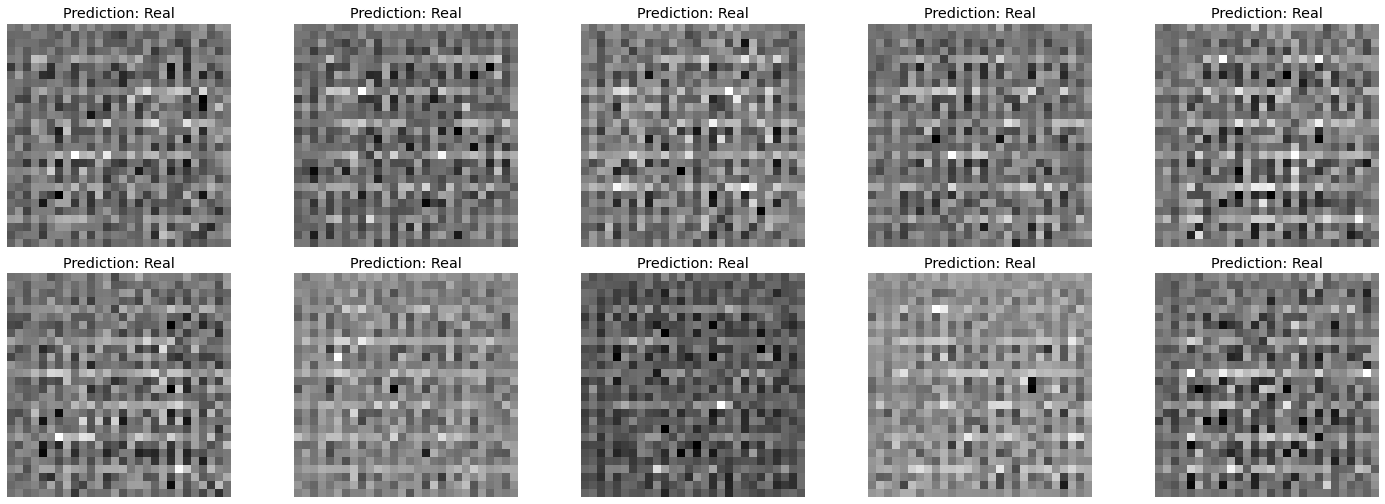

In [ ]:
generator = Generator()
discriminator = Discriminator()

noise_list = [tf.random.normal([1, 75]) for _ in range(10)]

visualize(noise_list, 0, 0, 0)

Epoch: 49

This epoch took 4.9937 seconds

The current generator loss: 3.5858

The current discriminator loss: 0.3442


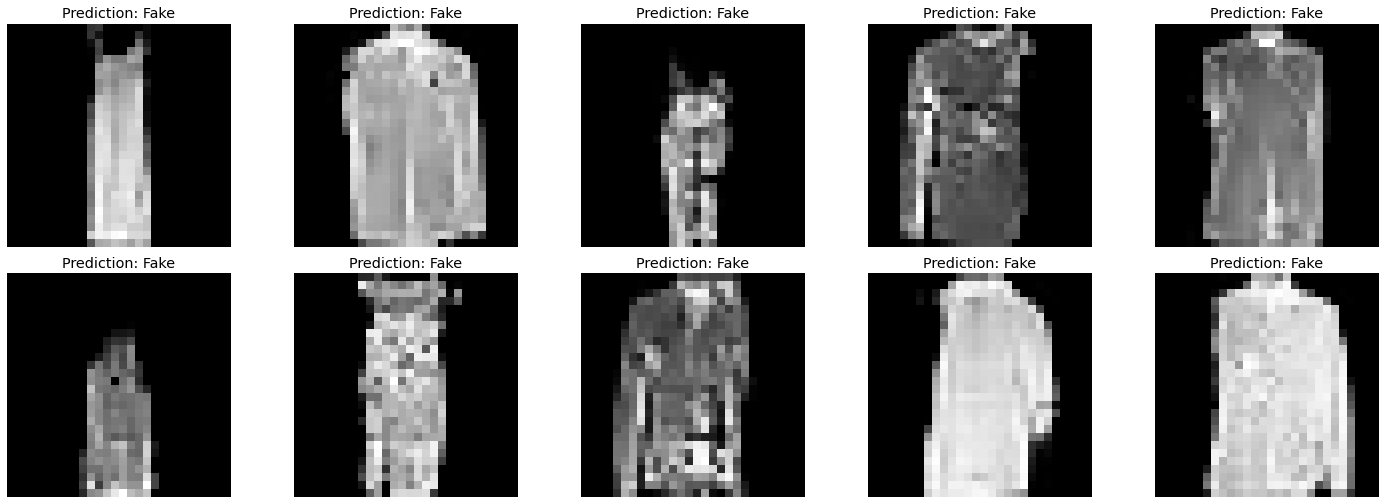

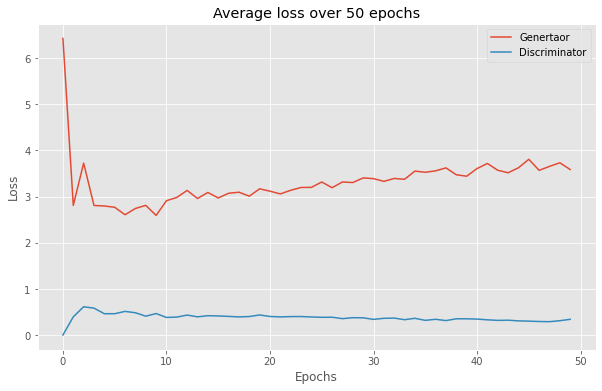

In [ ]:
trainGan()